In [20]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


In [21]:
# Функция SIR модели
def sir_model(t, y, beta, gamma):
    S, I, R = y
    beta = beta_interp(t)
    gamma = gamma_interp(t)
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    res = np.array([dSdt, dIdt, dRdt])
    return res


In [22]:
# Загрузка данных
data = pd.read_csv('for_eda_data.csv')
latvia_data = data[data.COUNTRY_NAME == 'Latvia']

Ldata = latvia_data.loc[:, ['ISO_START_DATE', 'Betta', 'Gamma', 'DETAILED_CASES_CONFIRMED']]
latvia_data.head()

,COUNTRY_NAME,ISO_START_DATE,ISO_YEAR,ISO_WEEK,AGEGROUP_NUM,DETAILED_CASES_CONFIRMED,DETAILED_CASES_DISCHARGED,Susceptible,Infected,Recovered,Betta,Gamma
989,Latvia,2020-03-02,2020,10,0,3,2,1886198,56585,18861,2.810818e-11,0.000035
990,Latvia,2020-03-09,2020,11,0,27,4,1886195,56586,18863,2.529691e-10,0.000071
991,Latvia,2020-03-16,2020,12,0,106,4,1886168,56609,18867,9.927345e-10,0.000071
992,Latvia,2020-03-23,2020,13,0,211,7,1886062,56711,18871,1.972549e-09,0.000123
993,Latvia,2020-03-30,2020,14,0,187,22,1885851,56915,18878,1.741918e-09,0.000387


In [23]:
list_column = ['ISO_START_DATE', 'DETAILED_CASES_CONFIRMED', 'DETAILED_CASES_DISCHARGED', 
               'Susceptible', 'Infected', 'Recovered', 'Betta', 'Gamma'
              ]

latvia_data = latvia_data[list_column]
latvia_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 989 to 1151
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ISO_START_DATE             163 non-null    object 
 1   DETAILED_CASES_CONFIRMED   163 non-null    int64  
 2   DETAILED_CASES_DISCHARGED  163 non-null    int64  
 3   Susceptible                163 non-null    int64  
 4   Infected                   163 non-null    int64  
 5   Recovered                  163 non-null    int64  
 6   Betta                      163 non-null    float64
 7   Gamma                      163 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 11.5+ KB


In [24]:
n = latvia_data.shape[0]
n

163

In [25]:
# Настройка гипперпараметров
p = 0.8 # разделение данных на тренировочные и тестовые
n_train = round(n * p)
n_test = round(n * (1-p))
p_beta, d_beta, q_beta = 1, 0, 2
p_gamma, d_gamma, q_gamma = 1, 1, 2

n_train, n_test

(130, 33)

In [26]:
# Разделение на обучающую и тестовую выборки
train_data = Ldata.iloc[:n_train]
test_data = Ldata.iloc[n_train:]
train_data.head()

,ISO_START_DATE,Betta,Gamma,DETAILED_CASES_CONFIRMED
989,2020-03-02,2.810818e-11,0.000035,3
990,2020-03-09,2.529691e-10,0.000071,27
991,2020-03-16,9.927345e-10,0.000071,106
992,2020-03-23,1.972549e-09,0.000123,211
993,2020-03-30,1.741918e-09,0.000387,187


In [27]:
# Моделирование и предсказание параметров с помощью ARIMA
model_beta = sm.tsa.ARIMA(train_data['Betta'], order=(p_beta, d_beta, q_beta)).fit()
model_gamma = sm.tsa.ARIMA(train_data['Gamma'], order=(p_gamma, d_gamma, q_gamma)).fit()
beta_forecast_ = model_beta.forecast(steps=n_test)
gamma_forecast_ = model_gamma.forecast(steps=n_test)

C:\Users\legyx\anaconda3\envs\forOtus\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\legyx\anaconda3\envs\forOtus\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\legyx\anaconda3\envs\forOtus\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\legyx\anaconda3\envs\forOtus\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\legyx\anaconda3\envs\forOtus\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

In [28]:
# Использование предсказанных параметров для моделирования SIR
y0 = [1886198, 56585, 18861] # y0 = [initial_susceptible, initial_infected, initial_recovered]
t = np.arange(0, n_train + n_test, 1)


In [29]:
# Объединение предсказанных параметров с данными
combined_data = pd.concat([train_data, test_data], axis=0)
combined_data['beta_forecast'] = np.concatenate([model_beta.fittedvalues, beta_forecast_])
combined_data['gamma_forecast'] = np.concatenate([model_gamma.fittedvalues, gamma_forecast_])

In [30]:
beta_forecast = combined_data['beta_forecast'].values.flatten()
gamma_forecast = combined_data['gamma_forecast'].values.flatten()

beta_interp = interp1d(t, beta_forecast)
gamma_interp = interp1d(t, gamma_forecast)


In [31]:
# Решение системы дифференциальных уравнений SIR
# solution = odeint(sir_model, y0, t, args=(combined_data['beta_forecast'], combined_data['gamma_forecast']))
# solution = solve_ivp(sir_model, [t[0], t[-1]], y0, args=(beta_forecast, gamma_forecast), t_eval=t)
solution = solve_ivp(
    fun=lambda t, y: sir_model(t-1, y, beta_interp, gamma_interp),
    t_span=[t[1], t[-1]],
    y0=y0,
    t_eval=t[1:]
)
S, I, R = solution.y
solution_df = pd.DataFrame({'S': S, 'I': I, 'R': R}, index=solution.t)
solution_df

,S,I,R
1,1.886198e+06,56585.000000,18861.000000
2,1.885572e+06,57209.998618,18861.967822
3,1.885522e+06,57257.214396,18865.122836
4,1.885325e+06,57450.518400,18868.813375
5,1.885008e+06,57764.473405,18871.599349
...,...,...,...
158,1.044359e+06,860753.520684,56531.212449
159,1.033573e+06,871273.227085,56797.760709
160,1.022722e+06,881854.598968,57067.564509
161,1.011815e+06,892488.451555,57340.639496


C:\Users\legyx\AppData\Local\Temp\ipykernel_14284\4027277170.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(t, latvia_data['Infected'][:len(t)], label='Infected (actual)')


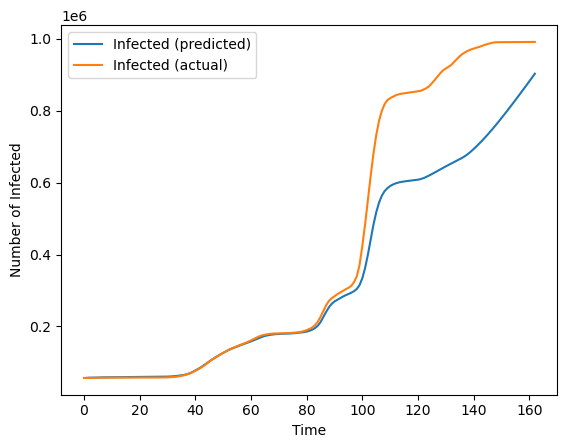

In [37]:
# Отображение результатов
plt.plot(t[1:], solution_df['I'], label='Infected (predicted)')
# plt.plot(t[:n_train], train_data['DETAILED_CASES_CONFIRMED'], label='Infected_train (actual)')
# plt.plot(t[n_train:], test_data['DETAILED_CASES_CONFIRMED'], label='Infected_test (actual)')
plt.plot(t, latvia_data['Infected'][:len(t)], label='Infected (actual)')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()

C:\Users\legyx\AppData\Local\Temp\ipykernel_14284\3860571745.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(t_beta, latvia_data['Betta'][n_train:], label='Beta (actual)')


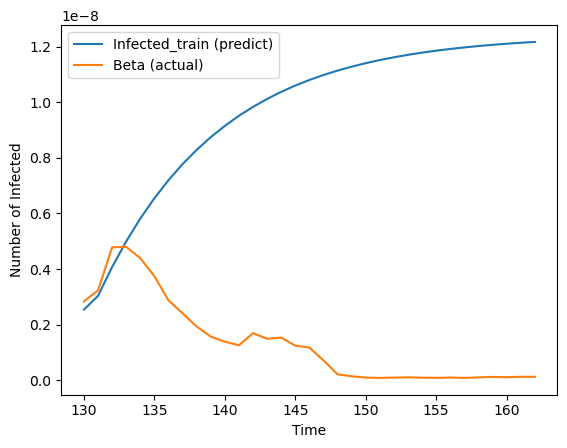

In [33]:
t_beta = t[n_train : n_train + len(beta_forecast_)]

plt.plot(t_beta, beta_forecast_, label='Infected_train (predict)')
plt.plot(t_beta, latvia_data['Betta'][n_train:], label='Beta (actual)')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()

C:\Users\legyx\AppData\Local\Temp\ipykernel_14284\204251195.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(t_beta, latvia_data['Gamma'][n_train:], label='Gamma (actual)')


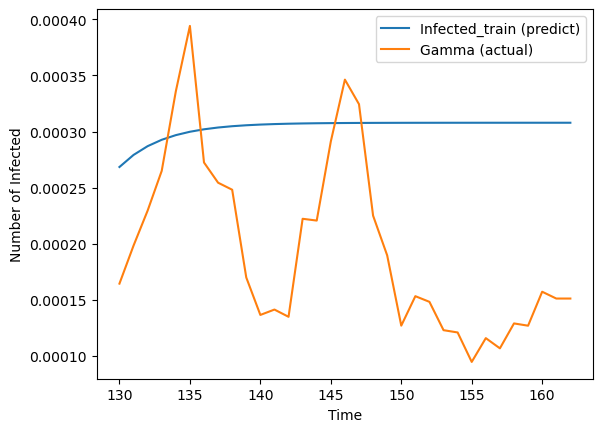

In [34]:
plt.plot(t_beta, gamma_forecast_, label='Infected_train (predict)')
plt.plot(t_beta, latvia_data['Gamma'][n_train:], label='Gamma (actual)')
plt.xlabel('Time')
plt.ylabel('Number of Infected')
plt.legend()
plt.show()

In [35]:
model_beta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Betta   No. Observations:                  130
Model:                 ARIMA(1, 0, 2)   Log Likelihood                1375.272
Date:                Mon, 26 Jun 2023   AIC                          -2740.544
Time:                        13:10:26   BIC                          -2726.207
Sample:                             0   HQIC                         -2734.718
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.242e-08   1.29e-20   9.65e+11      0.000    1.24e-08    1.24e-08
ar.L1          0.8894   1.34e-20   6.64e+19      0.000       0.889       0.889
ma.L1          0.7503   2.31e-21   3.25e+20      0.000       0.750       0.750
ma.L2          0.5052   4.03e-21   1.25e+20      0.000       0.505       0.505
sigma2          1e-10   1.74e-10      0.575      0.565   -2.41e-10    4.41e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               544.65
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.38e+37. Standard errors may be unstable.
"""

In [36]:
model_gamma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Gamma   No. Observations:                  130
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 850.021
Date:                Mon, 26 Jun 2023   AIC                          -1692.041
Time:                        13:10:26   BIC                          -1680.602
Sample:                             0   HQIC                         -1687.393
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7275      0.080      9.050      0.000       0.570       0.885
ma.L1         -0.8439      0.086     -9.819      0.000      -1.012      -0.675
ma.L2          0.4721      0.060      7.807      0.000       0.354       0.591
sigma2      1.097e-07   7.52e-09     14.580      0.000    9.49e-08    1.24e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2248.44
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -2.32
Prob(H) (two-sided):                  0.13   Kurtosis:                        22.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""